# Example

`solpolpy` is a solar polarization resolver based on [Deforest et al. 2022](https://doi.org/10.3847/1538-4357/ac43b6).
It converts between various polarization formats, e.g. from the native three triple version from observations
(also known as the MZP convention) to polarization brightness (pB) and total polarization (B), Stokes I, Q and U, etc.
An example of transforming the polarization basis using the LASCO/C2 images is 
shown in the image below.
The images at polarizing angles of -60°, 0° and +60° is shown in the top panel as 
Bm, Bz and Bp respectively.
The bottom panel shows the output of the `solpolpy` to convert the initial basis 
to the Stokes I, Q and U.

solpolpy is invoked using a simple interface:`output = sp.resolve(input_data, out_polarize_state, alpha=None, solar_ref_dir=None)`

where the _input\_data_ parameter is an appropriate data cube, such as a triplet of polarized images. _out_polarize_state_ is the desired output polarization state (MZP, BtBr, Stokes, BpB, Bp3, or Bthp).

An optional input parameter _mask_ can be used to include a user defined mask, if not solpolpy will derive one from the FITS metadata if possible.

An optional input parameter solar_ref_dir can be used to include a user defined solar reference direction. Not all instruments sepcify the zero polarization angle in the same direction, and can be included as solar_ref_dir='north', 'south', 'east', 'west'. If not specififed solpolpy will derive one from the FITS metadata if possible, or set to a default of 'north'.


### Polarization states handled by solpolpy

* Minus, Zero, Plus (MZP): Triplet of images taken at -60°, 0°, and +60° polarizing angles.

- Brightness<sub>Tangential</sub>, Brightness<sub>Radial</sub> (BtBr): Pair of images with polarization along the tangential and radial direction with respect to the Sun respectively.

- Stokes (Stokes): Total (unpolarized) brightness (I), polarized brightness along vertical and horizontal axes (Q) and polarized brightness along ±45° (U) .

- Brightness, polarized Brightness (BpB): Total (unpolarized) brightness and ‘excess polarized’ brightness images pair respectively.

- Brightness, polarized Brightness, polarized Brightness orthogonal (Bp3): Analogous to Stokes I, Q and U, but rotates with α around the Sun unlike the later with fixed frame of reference of the instrument.

- Brightness, theta, phi (Bthp): System with total (unpolarized) brightness, angle and degree of polarization.

### Import packages

In [1]:
import numpy as np
import glob
import solpolpy as sp
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.io import fits
from astropy.wcs import WCS
#from sunpy.map.sources import LASCOMap
from matplotlib import rcParams
from solpolpy.instruments import load_data
from ndcube import NDCube
#from solpolpy import support
rcParams['font.family'] = 'serif'

### support modules

As we're going to view several doublets and triplets, below is a handy subplot function used to create plots below.

In [2]:
def create_subplot(ax, data, meta, title, vmin, vmax, mask, color_map, fontsize = 18,
                   add_grid=False, add_colorbar=False):
    '''
    Creates axes for a matplotlib subplot.

    Input
    -----
    ax : number of axes
    data : input data set
    meta : wcs used to find date of observation
    vmin : doublet of min values
    vmax : doublet of max values
    fontsize = 18 : specify the font size for the output plot, , default is 18
    add_grid=False : if set adds a grid to the output plot, default is off
    add_colorbar=False : if set adds a colorbar to the output plot, default is off

    '''
 
    im = ax.imshow(data * mask, origin='lower', cmap=color_map, vmin=vmin, vmax=vmax)
    lon, lat = ax.coords
    lat.set_ticks(np.arange(-90, 90, 2) * u.degree)
    lon.set_ticks(np.arange(-180, 180, 2) * u.degree)
    lat.set_major_formatter('dd')
    lon.set_major_formatter('dd')
    ax.set_title(title, fontsize=fontsize)
    ax.set_xlabel('HP Longitude', fontsize=fontsize)
    ax.set_ylabel('HP Latitude', fontsize=fontsize)
    ax.text(0, 0, meta['DATE-OBS'][0:16], color='white', fontsize=fontsize)
    ax.tick_params(axis='both', labelsize=fontsize)
    
    if add_grid:
        ax.grid(color='white', ls='dotted')
    
    if add_colorbar:
        fig.colorbar(im, orientation='horizontal', ax=ax, shrink=0.9)

### Import Data

Import an example STEREO polarzation triplet dataset from 2010-04-03 at 10:10 UT

In [3]:
STEREO_triplet_FITS_files=[]
for f in glob.glob('data/stereo*.fts'):
    STEREO_triplet_FITS_files.append(f)

LASCO_triplet_FITS_files=[]
for f in glob.glob('data/lasco*.fts'):
    LASCO_triplet_FITS_files.append(f)

Use the solpolpy 'support' module create_oculter_mask to import data from a FITS file and create an occulter mask and the appropriate colormap. Although not required for a polarization transformation it improves data visibility. Below we create data arrays and masks for the stereo triplet above.

In [4]:
outcube_0 = sp.support.create_oculter_mask(STEREO_triplet_FITS_files[0])
outcube_120 = sp.support.create_oculter_mask(STEREO_triplet_FITS_files[1])
outcube_240 = sp.support.create_oculter_mask(STEREO_triplet_FITS_files[2])

color_map=sp.support.create_color_map_name(STEREO_triplet_FITS_files[0])

keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
Set MJD-AVG to 55289.423218 from DATE-AVG.
Set MJD-END to 55289.423345 from DATE-END'. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
Set MJD-AVG to 55289.422870 from DATE-AVG.
Set MJD-END to 55289.422998 from DATE-END'. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
Set MJD-AVG to 55289.422523 from DATE-AVG.
Set MJD-END to 55289.422651 from DATE-END'. [astropy.wcs.wcs]


We can create an example World Coordinate System object from the header information using the astropy package

In [5]:
outcube_0.wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'HPLN-TAN'  'HPLT-TAN'  
CRVAL : 7.279631111111111e-06  6.773759166666668e-05  
CRPIX : 1017.8  1024.9  
PC1_1 PC1_2  : 0.99095847  -0.13416896  
PC2_1 PC2_2  : 0.13416896  0.99095847  
CDELT : 0.004083333333333333  0.004083333333333333  
NAXIS : 2048  2048


We can view the header information

In [6]:
outcube_0.meta[0:10]

SIMPLE  =                    T / Written by IDL:  Mon Apr  5 17:12:11 2010      
BITPIX  =                   16 /                                                
NAXIS   =                    2 /                                                
NAXIS1  =                 2048 /                                                
NAXIS2  =                 2048 /                                                
EXTEND  =                    T /                                                
DATE-OBS= '2010-04-03T10:09:15.006' /                                           
FILEORIG= 'A4030234.411'       /                                                
SEB_PROG= 'NORMAL  '           /                                                
SYNC    =                    T /                                                

### View the STEREO triplet input data

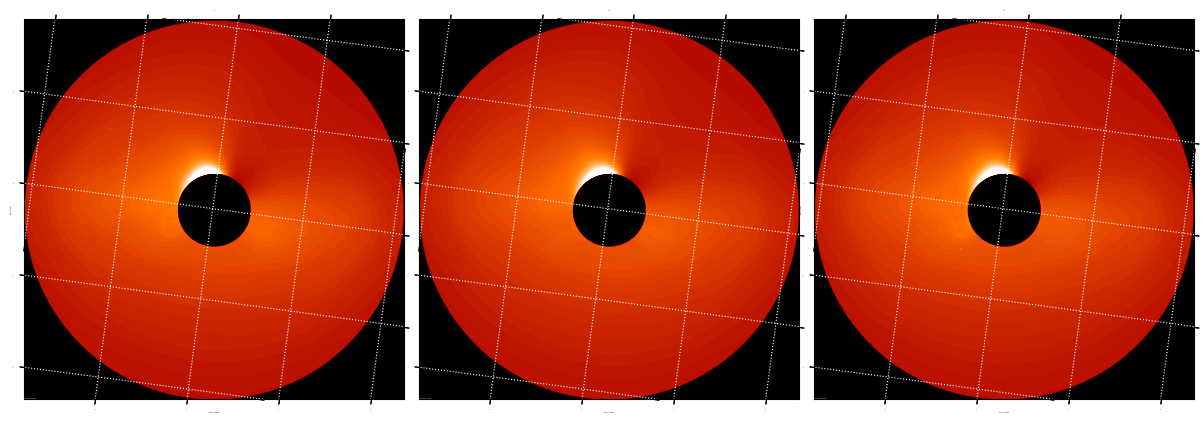

In [7]:
fig, axes = plt.subplots(1, 3, 
                         figsize=(12, 8), 
                         tight_layout=True,
                         sharey=True,
                         subplot_kw={'projection': outcube_0.wcs})

# Define data, metadata and titles for subplots
data_list = [outcube_0.data, outcube_120.data, outcube_240.data]
meta_list = [outcube_0.meta, outcube_120.meta, outcube_240.meta]
titles = ['0', '120', '240']
vmins = [0, 0, 0]
vmaxs = [10000, 10000, 10000]

# Create subplots using the create_subplot function
for i, axis in enumerate(axes):
    add_grid = True  # Change this to False if you don't want the grid
    add_colorbar = True  # Change this to False if you don't want the colorbar
    create_subplot(axis, data_list[i], meta_list[i], titles[i], vmins[i], 
                   vmaxs[i], outcube_0.mask, color_map, add_grid, add_colorbar)

plt.show()

### solpolpy Example 1: Resolve STEREO triplet into a Brightness - polarized Brightness pair 

In [8]:
output_bpb = sp.resolve(STEREO_triplet_FITS_files, 'BpB')

keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
Set MJD-AVG to 55289.423218 from DATE-AVG.
Set MJD-END to 55289.423345 from DATE-END'. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
Set MJD-AVG to 55289.422870 from DATE-AVG.
Set MJD-END to 55289.422998 from DATE-END'. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
Set MJD-AVG to 55289.422523 from DATE-AVG.
Set MJD-END to 55289.422651 from DATE-END'. [astropy.wcs.wcs]


### View the output data keys

solpolpy uses SunPy's ndcube.NDCollection to store datasets, the output datasets produced are represented by their _keys_ which can be accessed through the _keys_ object.

In [9]:
output_bpb.keys()

dict_keys(['B', 'pB', 'alpha'])

In this example we have converted the STEREO image triplet into a brightness - polarized brightness (BpB) pair. We see three keys are present in the output NDcollection, the brightness 'B', and, the polarized brightness 'pB' array, as well as the alpha array used to produce the pair. More information on the alpha parameter can be found in  [Deforest et al. 2022](https://doi.org/10.3847/1538-4357/ac43b6).

We can use the keys to access basic world coordinate system (wcs) information included with each dataset in the NDcollection, below we show the brightness array wcs.

In [10]:
output_bpb['B'].wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'HPLN-TAN'  'HPLT-TAN'  
CRVAL : 7.279631111111111e-06  6.773759166666668e-05  
CRPIX : 1017.8  1024.9  
PC1_1 PC1_2  : 0.99095847  -0.13416896  
PC2_1 PC2_2  : 0.13416896  0.99095847  
CDELT : 0.004083333333333333  0.004083333333333333  
NAXIS : 2048  2048

We can also access the metadata in each dataset, passed from the input dataset.

In [11]:
output_bpb['B'].meta[0:10]

SIMPLE  =                    T / Written by IDL:  Mon Apr  5 17:12:11 2010      
BITPIX  =                   16 /                                                
NAXIS   =                    2 /                                                
NAXIS1  =                 2048 /                                                
NAXIS2  =                 2048 /                                                
EXTEND  =                    T /                                                
DATE-OBS= '2010-04-03T10:09:15.006' /                                           
FILEORIG= 'A4030234.411'       /                                                
SEB_PROG= 'NORMAL  '           /                                                
SYNC    =                    T /                                                

Similarly we can access the data in each dataset

In [12]:
output_bpb['B'].data

array([[4118.66666667, 4117.33333333, 4116.        , ..., 4118.66666667,
        4118.66666667, 4117.33333333],
       [4122.66666667, 4121.33333333, 4117.33333333, ..., 4118.66666667,
        4120.        , 4118.66666667],
       [4125.33333333, 4121.33333333, 4117.33333333, ..., 4118.66666667,
        4120.        , 4118.66666667],
       ...,
       [4120.        , 4116.        , 4113.33333333, ..., 4114.66666667,
        4117.33333333, 4117.33333333],
       [4121.33333333, 4118.66666667, 4116.        , ..., 4118.66666667,
        4118.66666667, 4117.33333333],
       [4124.        , 4121.33333333, 4118.66666667, ..., 4121.33333333,
        4120.        , 4118.66666667]])

### Viewing the output

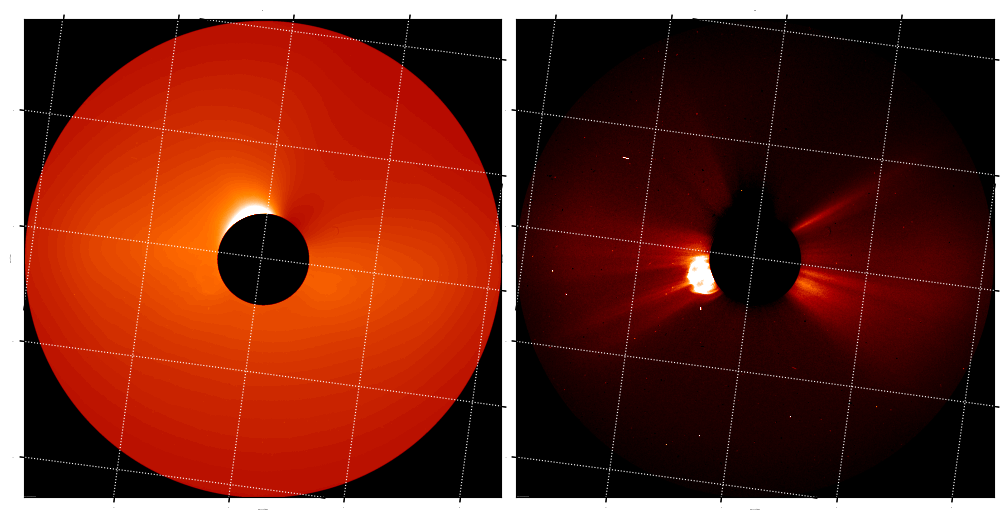

In [13]:
fig, axes = plt.subplots(1, 2, 
                         figsize=(10, 8), 
                         tight_layout=True, 
                         subplot_kw={'projection': output_bpb['B'].wcs},
                         sharey=True)

# Define data, metadata and titles for subplots
data_list = [output_bpb['B'].data, output_bpb['pB'].data]
meta_list = [output_bpb['B'].meta, output_bpb['pB'].meta]
titles = ['B', 'pB']
vmins = [0, 0]
vmaxs = [20000, 400]

# Create subplots using the create_subplot function
for i, ax in enumerate(axes):
    add_grid = True  # Change this to False if you don't want the grid
    add_colorbar = True  # Change this to False if you don't want the colorbar
    create_subplot(ax, data_list[i], meta_list[i], 
                   titles[i], vmins[i], vmaxs[i], 
                   outcube_0.mask, color_map, 
                   add_grid, add_colorbar)

plt.show()

### solpolpy Example 2: Resolve STEREO Brightness - polarized Brightness pair into a Stokes triplet

We can in turn reolve the output polarization Brightness - polarized Brightness pair into a Stokes triplet, following the methodology outlined above.

In [14]:
output_stokes = sp.resolve(output_bpb, 'Stokes')

Once again we can look at the keys in the output NDcollection

In [15]:
output_stokes.keys()

dict_keys(['Bi', 'Bq', 'Bu'])

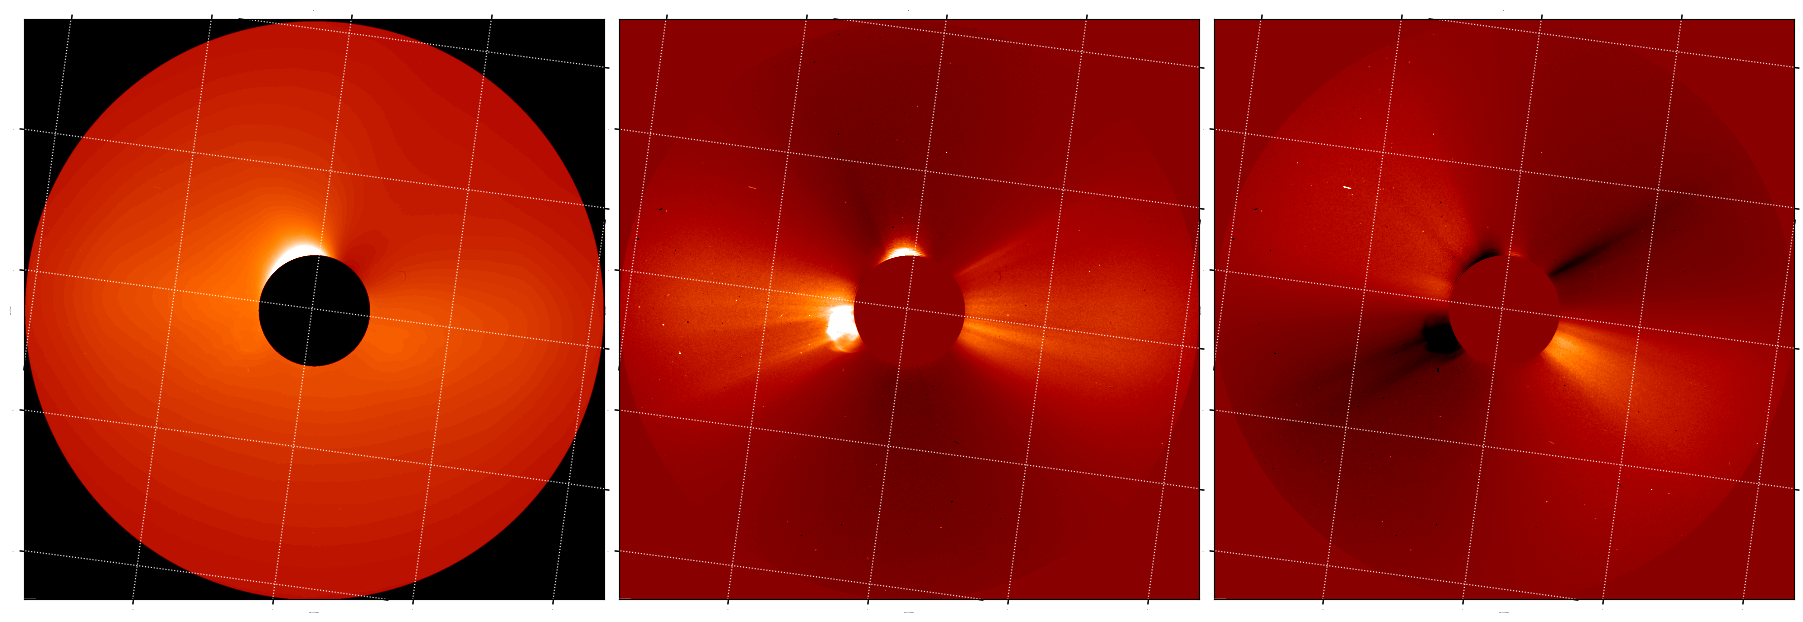

In [16]:
wcs = output_stokes['Bi'].wcs

# Create the figure
fig, axes = plt.subplots(1, 3, figsize=(18, 12), tight_layout=True, subplot_kw={'projection': wcs}, sharey=True)

# Define data and titles for subplots
data_list = [output_stokes['Bi'].data, output_stokes['Bq'].data, output_stokes['Bu'].data]
meta_list = [output_stokes['Bi'].meta, output_stokes['Bq'].meta, output_stokes['Bu'].meta]
titles = ['Bi', 'Bq', 'Bu']
vmins = [0, -100, -100]
vmaxs = [20000, 500, 500]

# Create subplots using the create_subplot function
for i, ax in enumerate(axes):
    add_grid = True  # Change this to False if you don't want the grid
    add_colorbar = True  # Change this to False if you don't want the colorbar
    create_subplot(ax, data_list[i], meta_list[i], titles[i], 
                   vmins[i], vmaxs[i], outcube_0.mask, color_map, 
                   add_grid, add_colorbar)

plt.show()